# start

In [1]:
import os
import pandas as pd
import numpy as np
import time
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
import tensorflow as tf
import torch
import torch.nn as nn
from collections import defaultdict
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from rdkit.Chem.rdmolops import FastFindRings
from torch.nn import Parameter
import warnings
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
warnings.filterwarnings('ignore')

In [2]:
data_file = '../data1/data1.csv'
mol_dir = '../data1/data1_sdf_files/'

In [3]:
tmp_df = pd.read_csv(data_file)
lig_smiles = tmp_df['Ligand'].to_list()
add_smiles = tmp_df['Additive'].to_list()
base_smiles = tmp_df['Base'].to_list()
ar_ha_smiles = tmp_df['Aryl halide'].to_list()
labels = np.array(tmp_df['Output'].to_list())

lig_smi_set = list(set(lig_smiles))
add_smi_set = list(set(add_smiles))
base_smi_set = list(set(base_smiles))
ar_ha_smi_set = list(set(ar_ha_smiles))

In [4]:
def Nodes_feat(mol):

    atom_feats_dict = defaultdict(list)
    is_donor = defaultdict(int)
    is_acceptor = defaultdict(int)
    
    
    fdef_name = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
    mol.UpdatePropertyCache()
    FastFindRings(mol)
    mol_featurizer = ChemicalFeatures.BuildFeatureFactory(fdef_name)
    
    mol_feats = mol_featurizer.GetFeaturesForMol(mol)
    mol_conformers = mol.GetConformers()
       
    assert len(mol_conformers) == 1
    geom = mol_conformers[0].GetPositions()
    
    
    for i in range(len(mol_feats)):
        if mol_feats[i].GetFamily() == 'Donor':
            node_list = mol_feats[i].GetAtomIds()
            for u in node_list:
                is_donor[u] = 1
        elif mol_feats[i].GetFamily() == 'Acceptor':
            node_list = mol_feats[i].GetAtomIds()
            for u in node_list:
                is_acceptor[u] = 1
    
    num_atoms = mol.GetNumAtoms()
    
    atoms = mol.GetAtoms()
    AllChem.ComputeGasteigerCharges(mol)
    atom_types = [atom.GetAtomicNum() for atom in atoms]
    rdkit_period_table = Chem.GetPeriodicTable()
    radius = np.array([rdkit_period_table.GetRvdw(item) for item in atom_types])
    charge=[atom.GetDoubleProp('_GasteigerCharge') for atom in atoms]

    
    conformer = mol.GetConformer()
    positions = conformer.GetPositions()
    h_u = []    
    for u in range(num_atoms):
        ato = mol.GetAtomWithIdx(u)
        symbol = ato.GetSymbol()
        atom_type = ato.GetAtomicNum()
        aromatic = ato.GetIsAromatic()
        hybridization = ato.GetHybridization()
        #print(u)

        
        num_h = ato.GetTotalNumHs()#相连氢原子个数
        atom_feats_dict['pos'].append(torch.FloatTensor(geom[u]))
        atom_feats_dict['node_type'].append(atom_type)
       
       
        h_u += [
            int(symbol == x) for x in ['H', 'C', 'N', 'O', 'F', 'S', 'Cl']
        ]
        h_u.append(atom_type)
        h_u.append(is_acceptor[u])
        h_u.append(is_donor[u])
        h_u.append(int(aromatic))
        h_u += [
            int(hybridization == x)
            for x in (Chem.rdchem.HybridizationType.SP,
                      Chem.rdchem.HybridizationType.SP2,
                      Chem.rdchem.HybridizationType.SP3)
        ]
        h_u.append(num_h)
    h_u=np.array(h_u).reshape(-1,15)
    return h_u

In [5]:
def PackMat(arr_list):
    N = len(arr_list)
    M = max([np.array(arr_list[i]).shape[0] for i in range(len(arr_list))])
    pack_mat = np.zeros([N, M, 15])
    for i in range(N):
        for j in range(len(arr_list[i])):
            pack_mat[i, :len(arr_list[i]), :] = arr_list[i][j]
    return pack_mat

In [6]:
def sort_func(x): return eval(x.split('/')[-1].split('.')[0].split('_')[-1])
lig_files = sorted(glob.glob(mol_dir+'lig_*.sdf'),key=sort_func)
add_files = sorted(glob.glob(mol_dir+'add_*.sdf'),key=sort_func)
base_files = sorted(glob.glob(mol_dir+'base_*.sdf'),key=sort_func)
ar_ha_files = sorted(glob.glob(mol_dir+'ar_ha_*.sdf'),key=sort_func)

sdf_file=lig_files+add_files+base_files+ar_ha_files
with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()
smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

In [7]:
def Calc_feat(file_list):
    
    all_atom_feats=[]
    feat_name_dict = {}
    for index, tmp_file in enumerate(file_list):
        tmp_fn = tmp_file.split('/')[-1].split('.')[0]
        feat_name_dict[tmp_fn] = index
        mol = Chem.MolFromMolFile(tmp_file,removeHs=False)
        num_atoms = mol.GetNumAtoms()
        print(tmp_file)
        atom_feats=[]
        for i in range(num_atoms):
            feat= Nodes_feat(mol)
            atom_feats.append(feat)
        all_atom_feats.append(atom_feats)
    all_atom_feats=np.array(all_atom_feats)
    all_atom_feats = PackMat(all_atom_feats)
    return all_atom_feats,feat_name_dict

In [8]:
lig_feat,lig_feat_name_dict=Calc_feat(lig_files)

../data1/data1_sdf_files/lig_0.sdf
../data1/data1_sdf_files/lig_1.sdf
../data1/data1_sdf_files/lig_2.sdf
../data1/data1_sdf_files/lig_3.sdf


In [9]:
ar_ha_feat,ar_ha_feat_name_dict=Calc_feat(ar_ha_files)

../data1/data1_sdf_files/ar_ha_0.sdf
../data1/data1_sdf_files/ar_ha_1.sdf
../data1/data1_sdf_files/ar_ha_2.sdf
../data1/data1_sdf_files/ar_ha_3.sdf
../data1/data1_sdf_files/ar_ha_4.sdf
../data1/data1_sdf_files/ar_ha_5.sdf
../data1/data1_sdf_files/ar_ha_6.sdf
../data1/data1_sdf_files/ar_ha_7.sdf
../data1/data1_sdf_files/ar_ha_8.sdf
../data1/data1_sdf_files/ar_ha_9.sdf
../data1/data1_sdf_files/ar_ha_10.sdf
../data1/data1_sdf_files/ar_ha_11.sdf
../data1/data1_sdf_files/ar_ha_12.sdf
../data1/data1_sdf_files/ar_ha_13.sdf
../data1/data1_sdf_files/ar_ha_14.sdf


In [10]:
base_feat,base_feat_name_dict=Calc_feat(base_files)

../data1/data1_sdf_files/base_0.sdf
../data1/data1_sdf_files/base_1.sdf
../data1/data1_sdf_files/base_2.sdf


In [11]:
add_feat,add_feat_name_dict=Calc_feat(add_files)

../data1/data1_sdf_files/add_0.sdf
../data1/data1_sdf_files/add_1.sdf
../data1/data1_sdf_files/add_2.sdf
../data1/data1_sdf_files/add_3.sdf
../data1/data1_sdf_files/add_4.sdf
../data1/data1_sdf_files/add_5.sdf
../data1/data1_sdf_files/add_6.sdf
../data1/data1_sdf_files/add_7.sdf
../data1/data1_sdf_files/add_8.sdf
../data1/data1_sdf_files/add_9.sdf
../data1/data1_sdf_files/add_10.sdf
../data1/data1_sdf_files/add_11.sdf
../data1/data1_sdf_files/add_12.sdf
../data1/data1_sdf_files/add_13.sdf
../data1/data1_sdf_files/add_14.sdf
../data1/data1_sdf_files/add_15.sdf
../data1/data1_sdf_files/add_16.sdf
../data1/data1_sdf_files/add_17.sdf
../data1/data1_sdf_files/add_18.sdf
../data1/data1_sdf_files/add_19.sdf
../data1/data1_sdf_files/add_20.sdf
../data1/data1_sdf_files/add_21.sdf


In [12]:
total_lig_feat = np.array([lig_feat[lig_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in lig_smiles])
total_add_feat = np.array([add_feat[add_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in add_smiles])
total_base_feat = np.array([base_feat[base_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in base_smiles])
total_ar_ha_feat = np.array([ar_ha_feat[ar_ha_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in ar_ha_smiles])

In [13]:
react_feat = np.concatenate([total_lig_feat,total_add_feat,total_base_feat,total_ar_ha_feat],axis=1)
labels_std = (np.array(labels)-np.min(labels))/(np.max(labels)-np.min(labels))

# train

In [14]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Multiply,LSTM
def z_score(arr):
    return (arr - tf.reduce_mean(arr))/tf.red(arr)
def max_min(arr):
    return (arr - np.min(arr))/(np.max(arr)-np.min(arr))
class SPMSElecMulAttentionNN(keras.Model):
    def __init__(self,lig_size,add_size,base_size,ar_ha_size,hidden_size=15,depth=10,
                 attention_depth=4,scaler_func=z_score,attention_depth_inter=1,inter_len=8,end_attention=1,fc_size=256):
        super(SPMSElecMulAttentionNN,self).__init__()
        self.lig_size = lig_size
        self.add_size = add_size
        self.base_size = base_size
        self.ar_ha_size = ar_ha_size
        self.hidden_size = hidden_size
        self.depth = depth
        self.inter_len=inter_len
        self.attention_depth=attention_depth
        self.end_attention=end_attention
        self.attention_depth_inter=attention_depth_inter
        
        self.scaler_func = scaler_func
        self.norm_lig = keras.layers.BatchNormalization()
        self.norm_add = keras.layers.BatchNormalization()
        self.norm_base = keras.layers.BatchNormalization()
        self.norm_ar_ha = keras.layers.BatchNormalization()
        
        self.lig_feat_init_layer = keras.layers.Dense(hidden_size,
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                      use_bias=False
                                                     )
        self.lig_feat_hidden_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                        use_bias=False
                                                       )
        self.lig_feat_final_layer = keras.layers.Dense(1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                       use_bias=False
                                                      )
        self.lig_feat_attention_dense = Dense(lig_size, activation='softmax', name='attention_vec')
        self.lig_feat_attention_mul =  Multiply()
        
        self.add_feat_init_layer = keras.layers.Dense(hidden_size,
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                      use_bias=False
                                                     )
        self.add_feat_hidden_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                        use_bias=False
                                                       )
        self.add_feat_final_layer = keras.layers.Dense(1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                       use_bias=False
                                                      )
        self.add_feat_attention_dense = Dense(add_size, activation='softmax', name='attention_vec')
        self.add_feat_attention_mul =  Multiply()
        
        self.base_feat_init_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                        use_bias=False
                                                       )
        self.base_feat_hidden_layer = keras.layers.Dense(hidden_size,
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                          use_bias=False
                                                         )
        self.base_feat_final_layer = keras.layers.Dense(1,
                                      kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                         use_bias=False
                                                        )
        self.base_feat_attention_dense = Dense(base_size, activation='softmax', name='attention_vec')
        self.base_feat_attention_mul =  Multiply()
        
        self.ar_ha_feat_init_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                        use_bias=False
                                                       )
        self.ar_ha_feat_hidden_layer = keras.layers.Dense(hidden_size,
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                          use_bias=False
                                                         )
        self.ar_ha_feat_final_layer = keras.layers.Dense(1,
                                      kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                         use_bias=False
                                                        )
        self.ar_ha_feat_attention_dense = Dense(ar_ha_size, activation='softmax', name='attention_vec')
        self.ar_ha_feat_attention_mul =  Multiply()        
        self.flatten = keras.layers.Flatten()
        self.fc_1 = keras.layers.Dense(256)
        self.fc_2 = keras.layers.Dense(256)
        self.fc_3 = keras.layers.Dense(1,activation='sigmoid')
        self.fc_5 = keras.layers.Dense(32)
        
        
        self.feat_number=32
        self.super_feat_attention_dense = Dense(self.feat_number, activation='softmax', name='attention_vec')
        self.super_feat_attention_mul =  Multiply() 
        
        self.conv2d_3 = keras.layers.Conv2D(1,(16,16))
        self.conv2d_4 = keras.layers.Conv2D(1,(8,8))
        self.conv2d_5 = keras.layers.Conv2D(1,(self.inter_len,self.inter_len))
        self.x_attention_dense = Dense(226, activation='softmax', name='attention_vec')
        self.x_attention_mul =  Multiply()           
        
        
        
    def call(self,input_):
        number_batch=len(input_)
        lig_x = input_[:,:self.lig_size,:]
        add_x = input_[:,self.lig_size:self.lig_size+self.add_size,:]
        base_x = input_[:,self.lig_size+self.add_size:self.lig_size+self.add_size+self.base_size,:]
        ar_ha_x = input_[:,self.lig_size+self.add_size+self.base_size:,:]

        lig_x=tf.reshape(lig_x,[-1,15,self.lig_size])
        add_x=tf.reshape(add_x,[-1,15,self.add_size])        
        base_x=tf.reshape(base_x,[-1,15,self.base_size])  
        ar_ha_x=tf.reshape(ar_ha_x,[-1,15,self.ar_ha_size])          
        for i in range(self.attention_depth):
            lig_x_=self.lig_feat_attention_dense(lig_x)
            lig_x=self.lig_feat_attention_mul([lig_x,lig_x_])    
            add_x_=self.add_feat_attention_dense(add_x)
            add_x=self.add_feat_attention_mul([add_x,add_x_])  
            base_x_=self.base_feat_attention_dense(base_x)
            base_x=self.base_feat_attention_mul([base_x,base_x_])
            ar_ha_x_=self.ar_ha_feat_attention_dense(ar_ha_x)
            ar_ha_x=self.ar_ha_feat_attention_mul([ar_ha_x,ar_ha_x_])            
        lig_x=tf.reshape(lig_x,[-1,self.lig_size,15])
        add_x=tf.reshape(add_x,[-1,self.add_size,15])        
        base_x=tf.reshape(base_x,[-1,self.base_size,15])          
        ar_ha_x=tf.reshape(ar_ha_x,[-1,self.ar_ha_size,15])         
      
        lig_x = self.lig_feat_init_layer(lig_x)
        for i in range(self.depth):
            lig_x = self.lig_feat_hidden_layer(lig_x)
            #cat_x = self.norm_cat(lig_x)
        #mean,variance = tf.nn.moments(lig_x,axes=None)
        #lig_x = (lig_x-mean)/variance
        lig_x = (lig_x - tf.reduce_min(lig_x))/(tf.reduce_max(lig_x)-tf.reduce_min(lig_x))
        lig_x = self.lig_feat_final_layer(lig_x)
        lig_x = self.norm_lig(lig_x)
        lig_x = tf.nn.tanh(lig_x)
        
        add_x = self.add_feat_init_layer(add_x)
        for i in range(self.depth):
            add_x = self.add_feat_hidden_layer(add_x)
            #add_x = self.norm_imine(add_x)
        #mean,variance = tf.nn.moments(add_x,axes=None)
        #add_x = (add_x-mean)/variance
        add_x = (add_x - tf.reduce_min(add_x))/(tf.reduce_max(add_x)-tf.reduce_min(add_x))
        add_x = self.add_feat_final_layer(add_x)
        add_x = self.norm_add(add_x)
        add_x = tf.nn.tanh(add_x)
        
        base_x = self.base_feat_init_layer(base_x)
        for i in range(self.depth):
            base_x = self.base_feat_hidden_layer(base_x)
            #base_x = self.norm_thiol(base_x)
        #mean,variance = tf.nn.moments(base_x,axes=None)
        #base_x = (base_x-mean)/variance
        base_x = (base_x - tf.reduce_min(base_x))/(tf.reduce_max(base_x)-tf.reduce_min(base_x))
        base_x = self.base_feat_final_layer(base_x)
        base_x = self.norm_base(base_x)
        base_x = tf.nn.tanh(base_x)
        
        ar_ha_x = self.ar_ha_feat_init_layer(ar_ha_x)
        for i in range(self.depth):
            ar_ha_x = self.ar_ha_feat_hidden_layer(ar_ha_x)
            #ar_ha_x = self.norm_thiol(ar_ha_x)
        #mean,variance = tf.nn.moments(ar_ha_x,axes=None)
        #ar_ha_x = (ar_ha_x-mean)/variance
        ar_ha_x = (ar_ha_x - tf.reduce_min(ar_ha_x))/(tf.reduce_max(ar_ha_x)-tf.reduce_min(ar_ha_x))
        ar_ha_x = self.ar_ha_feat_final_layer(ar_ha_x)
        ar_ha_x = self.norm_ar_ha(ar_ha_x)
        ar_ha_x = tf.nn.tanh(ar_ha_x)       
        react_feat_mat = tf.concat([lig_x,add_x,base_x,ar_ha_x],axis=1)        
        react_feat_mat=tf.reshape(react_feat_mat,[number_batch,217])
        #print('react_feat_mat',react_feat_mat.shape)
        react_feat_mat_=react_feat_mat
        react_feat_mat=self.fc_5(react_feat_mat)
        #print('react_feat_mat',react_feat_mat.shape)
        
        super_feat=tf.reshape(react_feat_mat,[number_batch,1,self.feat_number])
        #print('super_feat',super_feat.shape)
        #print('1super_spms shape',super_spms.shape)
        #print('1super_ele shape',super_ele.shape)
        for i in range(self.attention_depth_inter):
            super_feat_=self.super_feat_attention_dense(super_feat)
            super_feat=self.super_feat_attention_mul([super_feat,super_feat_])    

        #print('2super_spms shape',super_spms.shape)
        #print('2super_ele shape',super_ele.shape)
        
        react_feat_mat=tf.matmul(tf.reshape(react_feat_mat,[number_batch,self.feat_number,1]),super_feat)
        react_feat_mat=tf.reshape(react_feat_mat,[number_batch,self.feat_number,self.feat_number,1])
        #print('react_feat_mat',react_feat_mat.shape)
        react_feat_mat=self.conv2d_5(self.conv2d_4(self.conv2d_3(react_feat_mat)))
        #print('react_feat_mat',react_feat_mat.shape)
        react_feat_mat=tf.reshape(react_feat_mat,[number_batch,-1])
        #print('react_spms_x shape',react_spms_x.shape)
        #print('react_feat_mat',react_feat_mat.shape)
        #print('react_feat_mat_',react_feat_mat_.shape)

        #print('react_elec_x shape',react_elec_x.shape)
        
        x = tf.concat([react_feat_mat_,react_feat_mat],axis=1)
        #print('attention need',x.shape)
        x=tf.reshape(x,[number_batch,226])
        #print('attention need',x.shape)
        for i in range(self.end_attention):
            x_=self.x_attention_dense(x)
            x=self.x_attention_mul([x,x_])         
        #x = self.flatten(x)
        x = self.fc_3(self.fc_2(self.fc_1(x))) 
        return x

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(react_feat, labels_std, test_size=0.3, random_state=1000)

model = SPMSElecMulAttentionNN(107, 36, 56, 18,depth=2,attention_depth=1,hidden_size=15,attention_depth_inter=1,inter_len=8,end_attention=1,fc_size=256)
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 100
for epoch in range(EPOCHS):
    hist = model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),batch_size=2)
    #predict=model.predict(x_test)
    #print(mean_squared_error(y_test,predict))
    path = checkpoint.save('./dataset/run_data/data1_MG_MIGNN.ckpt')
    print("model saved to %s" % path)

2022-08-11 15:08:33.608899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 15:08:33.609479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-11 15:08:33.609490: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-11 15:08:33.609899: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow bin

1384/1384 [==============================] - 6s 3ms/step - loss: 0.0371 - val_loss: 0.0220
model saved to ./dataset/run_data/data1_MG_MIGNN.ckpt-1
1384/1384 [==============================] - 3s 2ms/step - loss: 0.0153 - val_loss: 0.0184
model saved to ./dataset/run_data/data1_MG_MIGNN.ckpt-2
1384/1384 [==============================] - 3s 2ms/step - loss: 0.0130 - val_loss: 0.0139
model saved to ./dataset/run_data/data1_MG_MIGNN.ckpt-3
1238/1384 [=========================>....] - ETA: 0s - loss: 0.0106

KeyboardInterrupt: 

In [27]:
all_rmse=[]
all_r2=[]
all_test_=[]
all_pred_=[]
for m in range(32,42):
    opt = tf.keras.optimizers.Adam()
    new_model = SPMSElecMulAttentionNN(107, 36, 56, 18,depth=4,attention_depth=1,
                                       hidden_size=15,attention_depth_inter=1,inter_len=8,end_attention=1,fc_size=256)
    new_model.compile(optimizer=opt,loss='mse')
    _ = new_model.fit(x=x_train,y=y_train,validation_data=(x_test, y_test),epochs=1)
    checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
    checkpoint.restore('./dataset/run_data/data1_MG_MIGNN.ckpt-%d'%(m))
    y_test_pre=new_model.predict(x_test)
    y_val = y_test*(np.max(labels)-np.min(labels))+np.min(labels)
    y_pred = y_test_pre*(np.max(labels)-np.min(labels))+np.min(labels)
    
    rmse=np.round((mean_squared_error(y_val,y_pred))**(0.5),3)
    r2=np.round(r2_score(y_val,y_pred),3)
    all_test_.append(y_val)
    all_pred_.append(y_pred)
    all_rmse.append(rmse)
    all_r2.append(r2)
    print(rmse,r2)

87/87 [==============================] - 3s 13ms/step - loss: 0.0591 - val_loss: 0.0739
7.309 0.928
87/87 [==============================] - 3s 13ms/step - loss: 0.0658 - val_loss: 0.0764
7.379 0.927
87/87 [==============================] - 3s 16ms/step - loss: 0.0634 - val_loss: 0.0730
7.862 0.917
87/87 [==============================] - 3s 13ms/step - loss: 0.0604 - val_loss: 0.0763
7.263 0.929
87/87 [==============================] - 3s 13ms/step - loss: 0.0639 - val_loss: 0.0761
10.026 0.864
87/87 [==============================] - 3s 13ms/step - loss: 0.0646 - val_loss: 0.0660
7.501 0.924
87/87 [==============================] - 3s 13ms/step - loss: 0.0631 - val_loss: 0.0816
7.574 0.923
87/87 [==============================] - 3s 13ms/step - loss: 0.0689 - val_loss: 0.0795
7.445 0.925
87/87 [==============================] - 3s 13ms/step - loss: 0.0545 - val_loss: 0.0753
9.788 0.871
87/87 [==============================] - 3s 13ms/step - loss: 0.0674 - val_loss: 0.0742
7.396 0.926

In [29]:
np.mean(all_rmse),np.mean(all_r2)

(7.954299999999999, 0.9134)

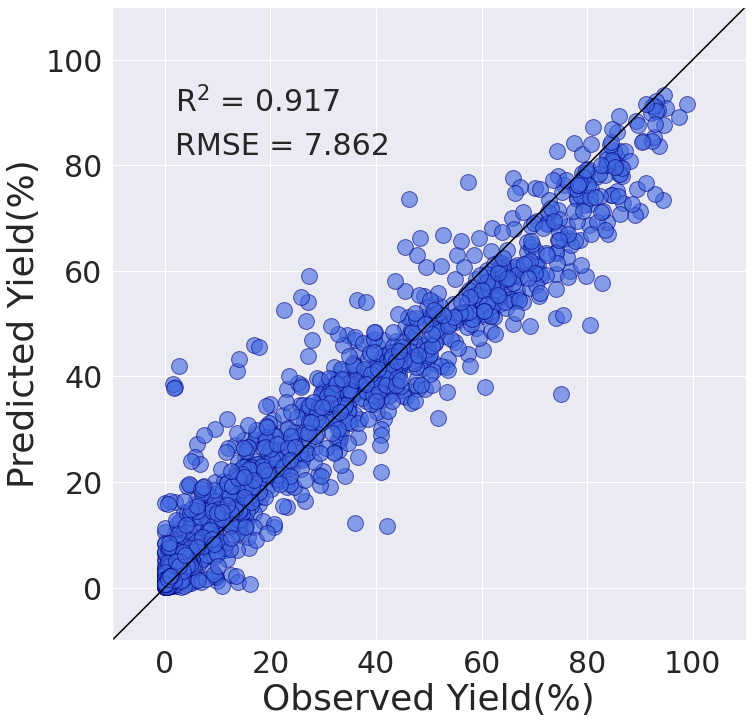

In [31]:
y_val=all_test_[2]
y_pred=all_pred_[2]
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-10,110],[-10,110],c='black')
'''x = np.arange(-1,5)
y = x
l = plt.plot(x,y)
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.fill_between(x,x+0.5,x-0.5,alpha=0.2,color='yellow')'''
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
#ax.set_facecolor('oldlace')#oldlace   mistyrose
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

plt.xlabel("Observed Yield(%)",fontsize=36)
plt.ylabel("Predicted Yield(%)",fontsize=36)
plt.tick_params(labelsize=30)
plt.text(2,82,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(2,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)


plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()


In [32]:
np.save('./dataset/data1_MG_MIGNN_all_test.npy',all_test_)
np.save('./dataset/data1_MG_MIGNN_all_pred.npy',all_pred_)

In [43]:
opt = tf.keras.optimizers.Adam()
new_model = SPMSElecMulAttentionNN(107, 36, 56, 18,depth=4,attention_depth=1,
                                   hidden_size=15,attention_depth_inter=1,inter_len=8,end_attention=1,fc_size=256)
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(x=x_train,y=y_train,validation_data=(x_test, y_test),epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./dataset/run_data/data1_MG_MIGNN.ckpt-84')
y_test_pre=new_model.predict(x_test)
y_test_for_draw = y_test*(np.max(labels)-np.min(labels))+np.min(labels)
y_test_pred_for_draw = y_test_pre*(np.max(labels)-np.min(labels))+np.min(labels)

react_feat_mat (None, 217)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, 32, 32, 1)
react_feat_mat (None, 3, 3, 1)
attention need (None, None)
attention need (None, 226)
react_feat_mat (None, 217)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, 32, 32, 1)
react_feat_mat (None, 3, 3, 1)
attention need (None, None)
attention need (None, 226)
87/87 [==============================] - ETA: 0s - loss: 0.0601react_feat_mat (None, 217)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, 32, 32, 1)
react_feat_mat (None, 3, 3, 1)
attention need (None, None)
attention need (None, 226)
87/87 [==============================] - 4s 18ms/step - loss: 0.0601 - val_loss: 0.0942
react_feat_mat (None, 217)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, 32, 32, 1)
react_feat_mat (None, 3, 3, 1)
attention need (None, None)
attention need (None, 226)
